# Hydrogen Chain Molecule Energy Calculation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from openfermion.chem import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermion.ops import FermionOperator
from openfermionpyscf import run_pyscf
from pyscf import fci

In [3]:
from qulacs import Observable, QuantumState, QuantumCircuit
from qulacs.observable import create_observable_from_openfermion_text
from qulacs.gate import X,Y,Z,H

N=4

def H_chain_geometry(N:int,d:int)->list:
    """
    return H chain geometry as list
    """
    geometry = []
    for i in range(N):
        geometry.append(["H",[0,0,round(d*i,5)]])
    return geometry

basis = "sto-3g"
multiplicity = 1
charge = 0
distance = 1.0
geometry = H_chain_geometry(N=N,d=distance)
molecule = MolecularData(geometry, basis, multiplicity, charge)
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
nqubit,nelectron = molecule.n_qubits,molecule.n_electrons

fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian) #<class 'openfermion.ops.operators.qubit_operator.QubitOperator'>
#print(type(jw_hamiltonian))
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))


exact_value = molecule.hf_energy
print("HF energy: {} (Hartree)".format(molecule.hf_energy))
print(nqubit,nelectron)

HF energy: -2.0985459369977626 (Hartree)
8 4


## HF Fock state definition

In [4]:
### Hartree Fock State
def HF_state(nqubit:int,nelectron:int):
    """
    returns HF state as qulacs.QuantumState
    """
    state = QuantumState(nqubit)
    circuit = QuantumCircuit(nqubit)
    for i in range(nelectron):
        circuit.add_gate(X(i))
    circuit.update_quantum_state(state)
    return state

hf_state = HF_state(nqubit=nqubit,nelectron=nelectron)
#hf_energy = qulacs_hamiltonian.get_expectation_value(hf_state)
#print(hf_energy)
#print(type(hf_state))

## prepare HOA hamiltonian

In [5]:
def Derive_q(S:int):
    """
    solve Simultaneous equations
    returns vector q as numpy.array
    """
    s = (S-1)/2
    M = []
    D = [0]*S
    D[1] = 1
    for i in range(S):
        M.append([])
        for j in range(S):
            M[-1].append((-s+j)**(i))
    M = np.array(M)
    q = np.linalg.inv(M)@D
    #q = np.round(np.linalg.inv(M)@D,15)
    #print(np.round(M@np.linalg.inv(M),8))
    #print(np.linalg.inv(M))
    #print(M)
    #print(D)
    return q

def Propagator(hamiltonian,t:float):
    """
    input hamiltonian as numpy.array
    construct a time evolution of Heisenberg Hamiltonian: U=e^{-iHt}
    returns array of the unitary matrix
    """
    unitary_mtrx = np.exp(-1j * hamiltonian * t)
    return unitary_mtrx

def H_Diff(S:int,delta:float,hamiltonian):
    """
    inputs: number of stential points S, distance of stential points, and QubitOperator hamiltonian.
    Construct HOA hamilotonian by size S and distance of neighboring points delta defined in the paper
    returns: array of the HOA hamilotonian
    """
    veq_q = Derive_q(S)
    hamiltonian=get_sparse_operator(hamiltonian).toarray()
    s=(S-1)/2
    H = Propagator(hamiltonian,-s*delta)*veq_q[0]
    for i in range(1,S):
        H+=Propagator(hamiltonian,(-s+i)*delta)*veq_q[i]
    return 1j/delta * H

def Array_HF_state(nqubit:int,nelectron:int):
    state = np.array([0]*(2**nqubit))
    state[2**nelectron-1] = 1
    return state[::-1]

HOA_hamil = H_Diff(S=11,delta=0.1,hamiltonian=jw_hamiltonian)
#print(len(HOA_hamil))
array_state = Array_HF_state(nqubit=nqubit,nelectron=nelectron)
#print(len(array_state))
HOA_value = np.real(array_state.T @ HOA_hamil @ array_state)
print(HOA_value)

-2.098545936874286


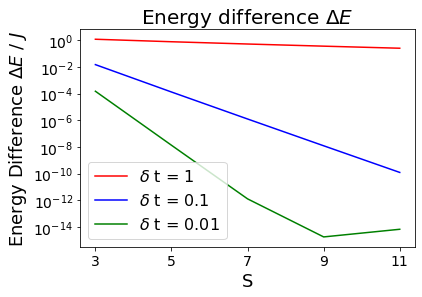

In [6]:
import matplotlib.pyplot as plt

list_S = [3,5,7,9,11]
## compare theoritical value and HOA results
### delta_t = 1
list_approx_value = []
for S in list_S:
    approx_value = array_state.T @ H_Diff(S=S,delta=1,hamiltonian=jw_hamiltonian) @ array_state
    list_approx_value.append(np.real(approx_value))
x=np.array(list_S)
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='red',label="$\delta$ t = 1")

### delta_t = 0.1
list_approx_value = []
for S in list_S:
    approx_value = array_state.T @ H_Diff(S=S,delta=0.1,hamiltonian=jw_hamiltonian) @ array_state
    list_approx_value.append(np.real(approx_value))
x=np.array(list_S)
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='blue',label="$\delta$ t = 0.1")

### delta_t = 0.01
list_approx_value = []
for S in list_S:
    approx_value = array_state.T @ H_Diff(S=S,delta=0.01,hamiltonian=jw_hamiltonian) @ array_state
    list_approx_value.append(np.real(approx_value))
x=np.array(list_S)
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='green',label="$\delta$ t = 0.01")


plt.title("Energy difference $\Delta E$",fontsize=20)
plt.xlabel('S',fontsize=18)
plt.ylabel('Energy Difference $\Delta E ~ / ~ J$',fontsize=18)
ax = plt.gca()
ax.set_yscale('log')
plt.grid([])
plt.xticks(list_S,fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc='lower left')
plt.show()

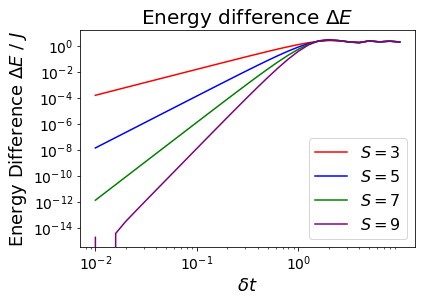

In [7]:
array_delta=10**np.linspace(-2,1,31)
### S=3
list_approx_value = []
for delta in array_delta:
    approx_value = array_state.T @ H_Diff(S=3,delta=delta,hamiltonian=jw_hamiltonian) @ array_state
    list_approx_value.append(np.real(approx_value))
x=np.array(array_delta)
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='red',label="$S = 3$")

### S=5
list_approx_value = []
for delta in array_delta:
    approx_value = array_state.T @ H_Diff(S=5,delta=delta,hamiltonian=jw_hamiltonian) @ array_state
    list_approx_value.append(np.real(approx_value))
x=np.array(array_delta)
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='blue',label="$S = 5$")


### S=7
list_approx_value = []
for delta in array_delta:
    approx_value = array_state.T @ H_Diff(S=7,delta=delta,hamiltonian=jw_hamiltonian) @ array_state
    list_approx_value.append(np.real(approx_value))
x=np.array(array_delta)
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='green',label="$S = 7$")

### S=9
list_approx_value = []
for delta in array_delta:
    approx_value = array_state.T @ H_Diff(S=9,delta=delta,hamiltonian=jw_hamiltonian) @ array_state
    list_approx_value.append(np.real(approx_value))
x=np.array(array_delta)
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='purple',label="$S = 9$")


plt.title("Energy difference $\Delta E$",fontsize=20)
plt.xlabel('$\delta t$',fontsize=18)
plt.ylabel('Energy Difference $\Delta E ~ / ~ J$',fontsize=18)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.grid([])
plt.xticks([0.01,0.1,1],fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc='lower right')
plt.show()